In [23]:
## Includes
using ValidatedNumerics
using PyPlot
using NLopt
using ForwardDiff
using Interact

# Deterministic Global Optimization for Continuous Functions
_Harry Watson, 18.337 Final Project, Fall 2016_

Despite the prevalence of optimization in the science and engineering community, comparatively little attention is given to deterministic methods for global optimization. The most commonly used "global" methods are multistart and meta-heuristic methods, which, while often effective, offer no guarantee of global optimality for nonconvex functions.

Instead, most algorithms for deterministic global optimization are based on the branch-and-bound framework (Horst and Tuy, 1996), which is implemented in this notebook.

## The Branch-and-Bound Algorithm

The problems that can be solved by a standard implementation of this algorithm are of the form:
\begin{align}
  \min_{\mathbf{x}\in X} \; & f(\mathbf{x}) \\
  \text{s.t.} \quad & \mathbf{g}(\mathbf{x})\leq\mathbf{0}, \\
  &\mathbf{h}(\mathbf{x})=\mathbf{0}
\end{align}
where $f:X\rightarrow\mathbb{R}$, $\mathbf{g}:X\rightarrow\mathbb{R}^{n_g}$ and $\mathbf{h}:X\rightarrow\mathbb{R}^{n_h}$. We'll assume these functions are continuously differentiable and that $X$ is a compact set.

A global solution of the (possibly) nonconvex nonlinear program is found by bounding the optimal objective function value between lower and upper bounds, starting on an initial simple set such as a multidimensional interval (box) that defines the full search space of the problem. After generating initial bounds, this initial set is then partitioned into smaller sets according to some heuristic, which is known as branching. The bounding subroutines are then run on these smaller sets to yield tighter bounds. Any feasible point for the problem can serve as an upper bound, although in practice, it is generally preferable to use a local optimization algorithm to locate a local minimum of the objective function. Lower bounds are generated by constructing convex underestimators of the original program, which can be solved to global optimality with local optimization algorithms to yield a valid bound. As this procedure of branching and bounding continues, any set on which the lower bound is greater than the best known upper bound can be discarded, and no further branching is performed on this set (this is called fathoming by value dominance). Subsets of the search space may also be fathomed due to infeasibility of the lower bounding problem. The procedure continues until the best feasible solution value and the current lower bound agree to within a preset tolerance.

### Branch and bound using intervals

The simplest "convex relaxation" we can generate on a given box is the constant bound given by evaluating the interval extension of our functions on the box and taking its the lower bound. Luckily, ValidatedNumerics.jl exists and provides the necessary interval arithmetic. We will use this strategy in the initial implementation of the branch-and-bound algorithm.

The next code block defines a type for a node in the branch-and-bound tree and an options structure for the user.

In [24]:
type babNode
    box::Vector{Interval{Float64}} ## Subproblem domain
    LB::Real ## Lower bound on subproblem
end

import Base.<
function <(node1::babNode, node2::babNode)
    if (node1.LB < node2.LB)
        return true;
    else
        return false;
    end
end

type options
    lbMethod::AbstractString ## Change lower bounding method ("Intervals" or "McCormick")
    rtol::Real        ## Relative termination tolerance
    atol::Real        ## Absolute termination tolerance
    maxNodes::Integer       ## Max nodes kept in memory at one time
    maxIterations::Integer  ## Max # of BaB iterations
    numIneqCons::Integer ## Number of inequality constraints
    numEqCons::Integer ## Number of equality constraints
end

options() = options("Intervals",1e-2,1e-8,10^5,10^5,0,0); ## Defaults

options

Main.babNode})(Array{ValidatedNumerics.Interval{Float64}, 1}, Real) in module Main at In[2]:2 overwritten at In[24]:2.


Below are the generic subroutines for the upper and lower bounding problems. The upper bounding problem is solved using NLopt.jl, and gradient information is generated automatically using ForwardDiff.jl.

In [25]:
## Interval version of lower-bounding problem
function LB_problem(probSize::Vector{Int64}, obj::Function, conIneq::Function, conEq::Function, box::Vector{Interval{Float64}})
    
    nx = probSize[1];
    nIneq = probSize[2];
    nEq = probSize[3];
    
    # Take solution as midpoint of box
    solution = Vector{Float64}(nx);
    for i = 1:nx
        solution[i] = (box[i].lo+box[i].hi)/2.0;
    end
    
    # Evaluate lower bound of objective on current box
    obj = obj(box);
    solutionValue = obj.lo;
    status = true;
    
    # Check constraint feasibility
    if nIneq > 0
        conIneq = conIneq(box);
        for i = 1:nIneq
            if conIneq[i].lo > 0.0
                solutionValue = -1e50;
                status = false;
            end
        end
    end
    if nEq > 0
        conEq = conEq(box);
        for i = 1:nEq
            if (conEq[i].lo > 0.0 || conEq[i].hi < 0.0)
                solutionValue = -1e50;
                status = false;
            end
        end
    end
    
    return solution, solutionValue, status;
end


## Upper bounding problem
function UB_problem(probSize::Vector{Int64}, obj::Function, conIneq::Function, conEq::Function, box::Vector{Interval{Float64}}, x0::Vector{Float64})
    
    nx = probSize[1];
    nIneq = probSize[2];
    nEq = probSize[3];
    
    opt = Opt(:LD_SLSQP, nx)
    
    lb = Vector{Float64}(nx);
    ub = Vector{Float64}(nx);
    for i=1:nx
        lb[i] = box[i].lo;
        ub[i] = box[i].hi;
    end

    lower_bounds!(opt,lb);
    upper_bounds!(opt, ub);  
    
    xtol_rel!(opt,1e-4);
    
    min_objective!(opt,(x,g)->objWrapperUB(x,g,obj));
    
    if nIneq > 0
        tol = 1.0e-6*ones(nIneq);
        inequality_constraint!(opt, (f,x,g)->conIneqWrapperUB(f,x,g,conIneq), tol);
    end
    if nEq > 0
        tol = 1.0e-6*ones(nEq);
        equality_constraint!(opt, (f,x,g)->conEqWrapperUB(f,x,g,conEq), tol);
    end
    
    (solutionValue,solution,ret) = optimize!(opt, x0);
    
    status = (ret==:XTOL_REACHED ? true : false);

    return solution, solutionValue, status;
end

## Wrappers for providing objective and constraint info to NLopt
function objWrapperUB(x::Vector, grad::Vector, obj::Function)
    g = x -> ForwardDiff.gradient(obj, x);
    if length(grad) > 0
        grad = g(x);
    end
    return obj(x);
end

function conIneqWrapperUB(result::Vector, x::Vector, grad::Matrix, conIneq::Function)
    g = x -> ForwardDiff.jacobian(conIneq, x);
    if length(grad) > 0
        grad = g(x)';
    end
    result = conIneq(x);
end

function conEqWrapperUB(result::Vector, x::Vector, grad::Matrix, conEq::Function)
    g = x -> ForwardDiff.jacobian(conEq, x);
    if length(grad) > 0
        grad = g(x)';
    end
    result = conEq(x);
end

conEqWrapperUB (generic function with 1 method)

, Function, Function, Function, Array{ValidatedNumerics.Interval{Float64}, 1}) in module Main at In[3]:4 overwritten at In[25]:4.


Below is the body of the branch-and-bound algorithm that manages the execution of the bounding subproblems.

In [26]:
## Main branch and bound algorithm
function bab(obj::Function, conIneq::Function, conEq::Function, X0::Vector{Interval{Float64}}, opt::options)
## Problem dimension 
nx = length(X0);
nIneq = opt.numIneqCons;
nEq = opt.numEqCons;
probSize = [nx, nIneq, nEq];
    
## Initialize 
rtol = opt.rtol; # Relative termination tolerance
atol = opt.atol; # Absolute termination tolerance
maxNodes = opt.maxNodes; # Max nodes in memory at one time
maxIterations = opt.maxIterations; # Max iterations before giving up
    
numIterations = 0;
numNodesRemaining = 1;
currentLowerBound = -1e50;
lowerBound = -1e50; 
currentUpperBound = 1e50;
upperBound = 1e50; 
currentSolution = Vector{Float64}(nx);
solution = Vector{Float64}(nx);
headNode = babNode(X0,lowerBound);
nodeList = Vector{babNode}(0); push!(nodeList,headNode);
currentNode = nodeList[1];
converged = false;
lbFeasible = false;  
ubFeasible = false;
index = 1;
    
while (~converged && numNodesRemaining > 0 && numNodesRemaining < maxNodes && numIterations < maxIterations)
    # Pick node for current iteration (the one with the least lower bound)  
    currentNode,index = findmin(nodeList);
    lowerBound = nodeList[index].LB;
    fathom = false;
       
    # Solve lower bounding problem
    if opt.lbMethod == "Intervals"
        ## Intervals
        currentSolution, currentLowerBound, lbFeasible = LB_problem(probSize, obj, conIneq, conEq, currentNode.box);
    elseif opt.lbMethod == "McCormick"
        ## McCormick relaxations
        currentSolution, currentLowerBound, lbFeasible = LB_problem2(probSize, obj, conIneq, conEq, currentNode.box);
    else
        println("\nInvalid lower bounding method specified.\n")
        return;
    end
    # Solve upper bounding problem
    if (lbFeasible)
        currentSolution, currentUpperBound, ubFeasible = UB_problem(probSize, obj, conIneq, conEq, currentNode.box,currentSolution);
            if (ubFeasible)
                if (currentUpperBound < upperBound)
                    # Update the solution if necessary and flag for fathoming by value dominance
                    upperBound = currentUpperBound;
                    solution = currentSolution;
                    fathom = true; 
            end  
            branchNode(nx, currentNode, currentLowerBound, nodeList); # Branch on current node
            numNodesRemaining += 2;
        end
    else
        ## Flag for fathom by infeasibility
        fathom = true;
    end
        
    # Delete visited node from list
    deleteat!(nodeList,index);
    numNodesRemaining -= 1;
    
    # Fathom tree
    if (fathom)
        numNodesFathomed = 0;
        numNodesFathomed = fathomTree(nodeList, upperBound);
        numNodesRemaining = numNodesRemaining - numNodesFathomed;
    end

    numIterations += 1;
    
        
        Abs_gap = upperBound-lowerBound;
        if (Abs_gap < rtol*abs(upperBound) || Abs_gap < atol)
            converged = true;
        end
        
        ## Print out when solution updates
        if (fathom && lbFeasible)
            println("\nIteration: ", numIterations, 
                    "\nNodes in memory: ", numNodesRemaining,
                    "\nCurrent solution found at: ", solution, " with value = ", upperBound, 
                    "\nBest possible solution value (lower bound): ", lowerBound,
                    "\nThe bounds are ", max(100*max(0.0,1.0-(Abs_gap)),100*max(0.0,1.0-(Abs_gap)/abs(upperBound))), "% converged.")
            
        end
        #@printf("%d || %d || %f || %f || %f\n", numIterations, numNodesRemaining, upperBound, lowerBound, 100*max(0.0,1.0-(Abs_gap)/abs(upperBound)) );
end
    
    if (numIterations >= maxIterations)
        println("Exceeded max number of iterations!")
    end
    if (numNodesRemaining >= maxNodes)
        println("Exceeded max number of nodes in memory!")
    end    
    Abs_gap = upperBound-lowerBound;
    println("\nBest solution found at: ", solution, " with value = ", upperBound, 
        "\nBest possible solution value (lower bound): ", lowerBound,
        "\nThe bounds are ", max(100*max(0.0,1.0-(Abs_gap)),100*max(0.0,1.0-(Abs_gap)/abs(upperBound))), "% converged.",
        "\nStatistics: ", numIterations," iterations");

end

function branchNode(nx::Integer, node::babNode, currentLB::Real, nodeList::Vector{babNode})
    
    # Find largest diameter of current node's box (absolute sense)
    max_width = node.box[1].hi - node.box[1].lo;
    branch_index = 1;
    
    for i = 1:nx    
        cur_width = (node.box[i].hi - node.box[i].lo);
        if (cur_width > max_width)
            max_width = cur_width;
            branch_index = i;
        end
    end
    
    #Bisect along that dimension
    tmp = node.box[branch_index];
    tmp1 = @interval(tmp.lo,(tmp.lo+tmp.hi)/2.0);
    tmp2 = @interval((tmp.lo+tmp.hi)/2.0, tmp.hi);
    
    box1 = Vector{Interval}(nx);
    box2 = Vector{Interval}(nx);
    for i=1:nx
        box1[i] = node.box[i];
        box2[i] = node.box[i];
    end
    
    box1[branch_index] = tmp1; 
    box2[branch_index] = tmp2;
    
    
    node1 = babNode(box1,currentLB);
    node2 = babNode(box2,currentLB);
    
    push!(nodeList,node1);
    push!(nodeList,node2);
  
end

function fathomTree(nodeList::Vector{babNode},upperBound::Real)
    i = 1;
    numNodesFathomed = 0;
    while(i <= length(nodeList))
        if (nodeList[i].LB > upperBound)
            deleteat!(nodeList,i);
            numNodesFathomed += 1;
        end
        i += 1;
    end
    return numNodesFathomed;
end



fathomTree (generic function with 1 method)

Function, Function, Array{ValidatedNumerics.Interval{Float64}, 1}, Main.options) in module Main at In[4]:4 overwritten at In[26]:4.


### Example: Six-Hump Camel Function

Find a global minimizer of:
\begin{equation}
f(\mathbf{x}) = (4 - 2.1x_1^2+\frac{1}{3}x_2^4)x_1^2 + x_1x_2 + (-4 + 4x_2^2)x_2^2
\end{equation}
on the 2-dimensional box $X = [-3,3]^2$ with no constraints.

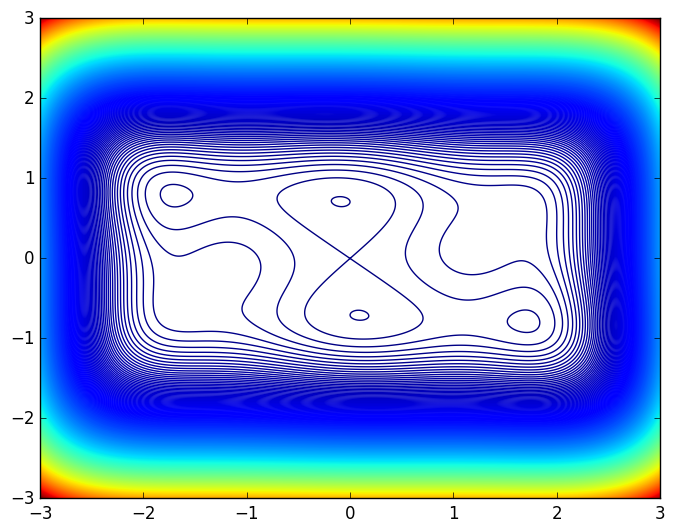

PyObject <matplotlib.contour.QuadContourSet object at 0x0000000036EC6EF0>

In [27]:
function sixHump(x::Vector)
    return (4.0 - 2.1*x[1]^2+(1./3.)*x[1]^4)*x[1]^2 + x[1]*x[2]+(-4.0 + 4.0*x[2]^2)*x[2]^2;
end

function noConstraint(x::Vector);
    return;
end


box = [(-3.0..3.0), (-3.0..3.0)]

## Plot the contours
xx = collect(-3.0:0.01:3.0);
zz = Matrix(length(xx),length(xx))
for i=1:length(xx)
    for j=1:length(xx)
        zz[i,j] = sixHump([xx[i],xx[j]])
    end
end
contour(xx,xx,zz',500)

In [28]:
opt = options("Intervals",1e-2,1e-8,10^5,10^5,0,0);
@time bab(sixHump, noConstraint, noConstraint, box, opt)

{T<:


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.0,0.0] with value = 0.0
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.

Iteration: 209
Nodes in memory: 168
Current solution found at: [-0.375,0.75] with value = -0.7437263488769531
Best possible solution value (lower bound): -12.881250000000001
The bounds are 0.0% converged.


Any, 1}) in module Main at In[5]:2 overwritten at In[27]:2.



Iteration: 785
Nodes in memory: 573
Current solution found at: [-0.1875,0.5625] with value = -0.8325981259346008
Best possible solution value (lower bound): -2.53125
The bounds are 0.0% converged.

Iteration: 812
Nodes in memory: 499
Current solution found at: [-0.09375,0.84375] with value = -0.8644770266488194
Best possible solution value (lower bound): -2.42578125
The bounds are 0.0% converged.

Iteration: 885
Nodes in memory: 503
Current solution found at: [-0.09375,0.5625] with value = -0.882913458533585
Best possible solution value (lower bound): -2.21484375
The bounds are 0.0% converged.

Iteration: 941
Nodes in memory: 489
Current solution found at: [-0.09375,0.65625] with value = -1.0072992922738195
Best possible solution value (lower bound): -2.07421875
The bounds are 0.0% converged.

Iteration: 1149
Nodes in memory: 572
Current solution found at: [-0.140625,0.703125] with value = -1.0204679281247082
Best possible solution value (lower bound): -1.6442033411934973
The bounds a

One issue with using natural interval extensions of functions in branch-and-bound is that the intervals only converge linearly to the true function as the width of the domain shrinks. To be precise, the definition of relaxation convergence order is given below.

**Definition**: Let $C \subset \mathbb{R}^{n}$ be a convex set and $\mathbb{I}C$ be the set of all interval subsets of $C$. Let a continuous convex relaxation of $f:C\rightarrow\mathbb{R}$ on any $X \in \mathbb{I}C$ be given by $f^{cv}_{X} : X \rightarrow \mathbb{R}$. The relaxations are said to have _convergence order_ $ \beta \geq 1$ if there exists $ K > 0$ such that:

\begin{equation}
\underset{{\bf x} \in X}{\text{min }} f({\bf x}) - \underset{{\bf x} \in X}{\text{min }} f^{cv}_{X}({\bf x}) \leq Kw(X)^{\beta},  \quad \forall X \in \mathbb{I}C, 
\end{equation}

where $w(X)$ is the width of an $n$-dimensional interval $X$, defined as $w(X) = \text{max}_{i = 1,...,n} (X_{i}^U-X_i^L)$.

In unconstrained optimization, linear convergence leads to the branch-and-bound algorithm having to search a very large number of boxes in the vicinity of minima (the "cluster problem"). 

We see this effect manifest if we make the termination tolerance tighter:

In [29]:
opt = options("Intervals",5e-3,1e-8,10^5,10^5,0,0);
@time bab(sixHump, noConstraint, noConstraint, box, opt)


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.0,0.0] with value = 0.0
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.

Iteration: 209
Nodes in memory: 168
Current solution found at: [-0.375,0.75] with value = -0.7437263488769531
Best possible solution value (lower bound): -12.881250000000001
The bounds are 0.0% converged.

Iteration: 785
Nodes in memory: 573
Current solution found at: [-0.1875,0.5625] with value = -0.8325981259346008
Best possible solution value (lower bound): -2.53125
The bounds are 0.0% converged.

Iteration: 812
Nodes in memory: 499
Current solution found at: [-0.09375,0.84375] with value = -0.8644770266488194
Best possible solution value (lower bound): -2.42578125
The bounds are 0.0% converged.

Iteration: 885
Nodes in memory: 503
Current solution found at: [-0.09375,0.5625] with value = -0.882913458533585
Best possible solution value (lower bound): -2.21484375
The bounds are 0.0% converged.

Iteration: 941
Nodes 

## McCormick's Relaxations (McCormick, 1976)

I now describe and implement an alternative method for bounding the range of a function. 

First introduced (though largely ignored for many years) by G.P. McCormick in 1976, this is an automatic method for constructing and evaluating convex underestimators and concave overestimators for finite compositions of:    
- Addition   
- Multiplication   
- Univariate intrinsic functions (sin/exp/log/pow/etc.)   

"McCormick arithmetic" can be thought of as an extension of interval arithmetic. Indeed, the McCormick convex/concave relaxations of a function are defined with respect to a specific interval domain, so an interval arithmetic library is needed (again, here I use ValidatedNumerics.jl).

These relaxations have the following attributes/properties:
- Computationally inexpensive (scalar multiple of function evaluation)
- Subgradients are computable using automatic differentiation techniques
- Converge quadratically to original function as domain shrinks (no clustering)
- Not necessarily differentiable


For this implementation, we think of a _McCormick object_ $\mathcal{Z}$ as an extension of an interval object, i.e.:
\begin{equation}
\mathcal{Z}=(Z^B,Z^C)=([z^L,z^U],[z^{cv},z^{cc}]).
\end{equation}
In implementation, it is most convenient to represent a McCormick object as an interval and a pair of real numbers (and associated derivative information), which leads to the following type:

In [8]:
type mc{T<:Real, U<:Integer}
    I::Interval{T}   # Bounding interval
    cv::T            # Convex relaxation
    cc::T            # Concave relaxation
    cvsub::Vector{T} # Gradient of convex relaxation
    ccsub::Vector{T} # Gradient of concave relaxation
    nsub::U          # Length of gradient vector
    constant::Bool   # Are relaxations constant (i.e. just an interval)?
    
    mc(interval,cv,cc,cvsub,ccsub,nsub,constant) = (length(cvsub) == nsub && length(ccsub) == nsub)? new(interval,cv,cc,cvsub,ccsub,nsub,constant) : error("Inconsistent subgradient size!");
end

In [9]:
## Constructors
mc() = mc(@interval(0.0),0.0,0.0,Vector{Float64}(0),Vector{Float64}(0),0,true);
mc{U<:Integer}(nsub::U) = mc(@interval(0.0),0.0,0.0,zeros(Float64,nsub),zeros(Float64,nsub),nsub,nsub>0 ? false : true);
mc{T<:Real}(I::Interval{T}) = mc(I,I.lo,I.hi,Vector{Float64}(0),Vector{Float64}(0),0,true);
mc{T<:Real}(I::Interval{T},c::T) = mc(I,c,c,Vector{Float64}(0),Vector{Float64}(0),0,false);
mc{T<:Real}(I::Interval{T},cv::T,cc::T) = mc(I,cv,cc,Vector{Float64}(0),Vector{Float64}(0),0,false);
mc{T<:Real,U<:Integer}(I::Interval{T},c::T,nsub::U) = mc(I,c,c,zeros(T,nsub),zeros(T,nsub),nsub,false);
mc{T<:Real}(I::Interval{T},cv::T,cc::T,cvsub::Vector{T},ccsub::Vector{T}) = mc(I,cv,cc,cvsub,ccsub,length(cvsub),false);
mc{T<:Real,U<:Integer}(I::Interval{T},cv::T,cc::T,nsub::U) = mc(I,cv,cc,zeros(T,nsub),zeros(T,nsub),nsub,false);
mc{T<:Real,U<:Integer}(I::Interval{T},cv::T,cc::T,cvsub::Vector{T},ccsub::Vector{T},nsub::U) = mc{T,U}(I,cv,cc,cvsub,ccsub,nsub,false);
mc{T<:Real,U<:Integer}(I::Interval{T},cv::T,cc::T,cvsub::Vector{T},ccsub::Vector{T},nsub::U,constant::Bool) = mc{T,U}(I,cv,cc,cvsub,ccsub,nsub,constant);

The next block of code implements the McCormick relaxations and their subgradients using operator overloading. It relies on Validated Numerics.jl as the underlying interval library. 

The basic rules for addition and multiplication are as follows:

\begin{equation} 
+(\mathcal{X},\mathcal{Y})=(X^B+Y^B,X^C+Y^C),
\end{equation}

\begin{equation}
\times(\mathcal{X},\mathcal{Y})=(X^BY^B,[z^{cv},z^{cc}]),
\end{equation}
where:
\begin{align*}
  z^{cv}&=\max\left(\left(y^LX^C+x^LY^C-x^Ly^L\right)^L, \left(y^UX^C+x^UY^C-x^U\,y^U\right)^L, (X^BY^B)^L\right),\\
  z^{cc}&=\min\left(\left(y^LX^C+x^UY^C-x^Uy^L\right)^U, \left(y^UX^C+x^LY^C-x^Ly^U\right)^U, (X^BY^B)^U\right).
\end{align*}

(Note that the product function is implemented equivalently but without using max/min below for ease of setting correct subgradients, in the style of the C++ code developed in my research group.)

Various univariate functions such as exp, log, sqrt, etc. also have "rules" for the construction of their convex/concave relaxation. For most of these, the function itself is either the convex or concave relaxation, and the other relaxation is given by the line segment that joins the function value at each end of the interval.

Finally, there is a rule for finite compositions of such functions:

Taking $u^{cv}(X,\cdot)$ and $u^{cc}(X,\cdot)$ which are known convex and concave relaxations of the univariate function $u$ on $X$, and $x^{\min}(X)$ and $x^{\max}(X)$ which are a minimum of $u^{cv}(X,\cdot)$ and a maximum of $u^{cc}(X,\cdot)$ on $X$, then (assuming all the domains/ranges are compatible), the composite convex relaxation $u(\mathcal{X})$ is given by:

\begin{equation}
  u(\mathcal{X})=\left(u(X^B),\left[u^{cv}(X^B,\text{mid}(x^{cv},x^{cc},x^{\min}(X^B))),
      u^{cc}(X^B,\text{mid}(x^{cv},x^{cc},x^{\max}(X^B)))\right]\cap u(X^B)\right).
\end{equation}

This result is implemented in the various univariate functions below.

In [10]:
## Helper functions

function cut(MC1::mc) ## cut relaxations at interval bounds
    if MC1.cv < MC1.I.lo 
        MC1.cv = MC1.I.lo;
        for i = 1:MC1.nsub
            MC1.cvsub[i] = 0.0;
        end
    end
    if MC1.cc > MC1.I.hi 
        MC1.cc = MC1.I.hi;
        for i = 1:MC1.nsub
            MC1.ccsub[i] = 0.0;
        end
    end
    return MC1;
end

function mid(a::Real, b::Real, c::Real)
  ## Return the mid value of three scalars; e.g., b if a <= b <= c
    if(( b <= a && a <= c ) || ( c <= a && a <= b )) 
        return a; 
    end
    if(( a <= b && b <= c ) || ( c <= b && b <= a )) 
        return b; 
    end
        return c;
 end

function mid(cv::Real, cc::Real, cut::Real, id::Integer)
    ## Return the mid value of three scalars cv, cc and cut, knowing that CONV <= CONC
    ## If the argument id is negative, the function indicates which value is the mid 
    if ( id < 0 )
        if ( cut < cv )
            id = 1; 
            return cv; 
        elseif ( cut > cc ) 
            id = 2; 
            return cc; 
        else                
            id = 0;  
            return cut;  
        end
    end

    ## If the argument id is nonnegative,the function returns the corresponding value, which is not necessarily the mid value
    if ( id == 1 ) 
        return cv;
    elseif ( id == 0  ) 
        return cut;
    else                    
        return cc;
    end
end

function mid( dcv::Vector, dcc::Vector, k::Integer, id::Integer )
    if( id == 1 ) 
        return dcv[k];
    elseif ( id == 0  ) 
        return 0.;
    else                    
        return dcc[k];
    end
end

function mid( dcv::Vector, dcc::Vector, dcut::Vector, k::Integer, id::Integer )
    if( id == 1 ) 
        return dcv[k];
    elseif ( id == 0  ) 
        return dcut[k];
    else                    
        return dcc[k];
    end
end

## Operator overloads

## Negation
import Base.- 
function -(MC1::mc)
    mcOut = mc(MC1.nsub);
    
    mcOut.I = (-MC1.I);
    mcOut.cv = -MC1.cc;
    mcOut.cc = -MC1.cv;

    if(!mcOut.constant)
        mcOut.cvsub = -MC1.ccsub;
        mcOut.ccsub = -MC1.cvsub;
    end
    return mcOut;
end

## Addition
import Base.+
function +(MC1::mc,x::Real) 
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I + x;
    mcOut.cv = MC1.cv + x;
    mcOut.cc = MC1.cc + x;
    mcOut.cvsub = MC1.cvsub;
    mcOut.ccsub = MC1.ccsub;
    return mcOut;
end

import Base.+
function +(x::Real,MC1::mc) 
    return MC1+x;
end

function sum1(MC1::mc, MC2::mc) ## MC2 constant
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I + MC2.I;
    mcOut.cv = MC1.cv + MC2.cv;
    mcOut.cc = MC1.cc + MC2.cc;
    mcOut.cvsub = MC1.cvsub;
    mcOut.ccsub = MC1.ccsub;
    return mcOut;
end

function sum2(MC1::mc, MC2::mc) ## Neither MC1 nor MC2 constant
    assert(MC1.nsub == MC2.nsub);
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I + MC2.I;
    mcOut.cv = MC1.cv + MC2.cv;
    mcOut.cc = MC1.cc + MC2.cc;
    mcOut.cvsub = MC1.cvsub + MC2.cvsub;
    mcOut.ccsub = MC1.ccsub + MC2.ccsub;
    return mcOut;
end

import Base.+
function +(MC1::mc,MC2::mc) 
    if (MC2.constant) 
        return sum1(MC1, MC2);
    end
    if (MC1.constant) 
        return sum1(MC2,MC1);
    end
    
    return sum2(MC1,MC2);
end

## Subtraction
import Base.-
function -(MC1::mc,x::Real) 
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I - x;
    mcOut.cv = MC1.cv - x;
    mcOut.cc = MC1.cc - x;
    mcOut.cvsub = MC1.cvsub;
    mcOut.ccsub = MC1.ccsub;
    return mcOut;
end

import Base.-
function -(x::Real,MC1::mc) 
    return -(MC1-x);
end

function sub1(MC1::mc, MC2::mc) ## MC2 constant
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I - MC2.I;
    mcOut.cv = MC1.cv - MC2.cc;
    mcOut.cc = MC1.cc - MC2.cv;
    mcOut.cvsub = MC1.cvsub;
    mcOut.ccsub = MC1.ccsub;
    return mcOut;
end

function sub2(MC1::mc, MC2::mc) ## MC1 constant
    mcOut = mc(MC2.nsub);
    mcOut.I = MC1.I - MC2.I;
    mcOut.cv = MC1.cv - MC2.cc;
    mcOut.cc = MC1.cc - MC2.cv;
    mcOut.cvsub = -MC2.ccsub;
    mcOut.ccsub = -MC2.cvsub;
    return mcOut;
end

function sub3(MC1::mc, MC2::mc) ## Neither MC1 nor MC2 constant
    assert(MC1.nsub == MC2.nsub);
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I - MC2.I;
    mcOut.cv = MC1.cv - MC2.cc;
    mcOut.cc = MC1.cc - MC2.cv;
    mcOut.cvsub = MC1.cvsub - MC2.ccsub;
    mcOut.ccsub = MC1.ccsub - MC2.cvsub;
    return mcOut;
end

import Base.-
function -(MC1::mc,MC2::mc) 
    if (MC2.constant) 
        return sub1(MC1, MC2);
    end
    if (MC1.constant) 
        return sub2(MC1,MC2);
    end
    
    return sub3(MC1,MC2);
end

## Multiplication
import Base.*
function *(MC1::mc,x::Real) 
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I * x;
    
    if (x >= 0.0)
        mcOut.cv = MC1.cv * x;
        mcOut.cc = MC1.cc * x;
        mcOut.cvsub = MC1.cvsub * x;
        mcOut.ccsub = MC1.ccsub * x;
    else
        mcOut.cv = MC1.cc * x;
        mcOut.cc = MC1.cv * x;
        mcOut.cvsub = MC1.ccsub * x;
        mcOut.ccsub = MC1.cvsub * x;        
    end
    
    return mcOut;
end

import Base.*
function *(x::Real,MC1::mc) 
    return MC1*x;
end

function mul1_mc1pos_mc2pos(MC1::mc, MC2::mc) ## MC2 constant, both positive
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cv+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC2.I.hi*MC1.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC2.I.lo*MC1.cvsub;
    end
    
    cc1 = MC2.I.lo*MC1.cc+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.lo*MC1.ccsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.hi*MC1.ccsub
    end
    
    return mcOut;
end

function mul2_mc1pos_mc2pos(MC1::mc, MC2::mc) ## Neither constant, both positive
    assert(MC1.nsub==MC2.nsub)
    mcOut = mc(MC1.nsub);
    
        mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cv+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC2.I.hi*MC1.cvsub + MC1.I.hi*MC2.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC2.I.lo*MC1.cvsub + MC1.I.lo*MC2.cvsub;
    end
    
    cc1 = MC2.I.lo*MC1.cc+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.lo*MC1.ccsub + MC1.I.hi*MC2.ccsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.hi*MC1.ccsub + MC1.I.lo*MC2.ccsub;
    end
    
    return mcOut;
end

function mul1_mc1pos_mc2mix(MC1::mc, MC2::mc) ## MC2 constant, 0 in MC2
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cc+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC2.I.hi*MC1.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC2.I.lo*MC1.ccsub;
    end
    
    cc1 = MC2.I.lo*MC1.cv+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.lo*MC1.cvsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.hi*MC1.ccsub;
    end
    return mcOut;
end

function mul2_mc1pos_mc2mix(MC1::mc, MC2::mc) ## MC1 constant, 0 in MC2
    mcOut = mc(MC2.nsub);
    mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cc+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC1.I.hi*MC2.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC1.I.lo*MC2.cvsub;
    end
    
    cc1 = MC2.I.lo*MC1.cv+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.hi*MC2.ccsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.lo*MC2.ccsub
    end    
    return mcOut;
end

function mul3_mc1pos_mc2mix(MC1::mc, MC2::mc) ## Neither constant, 0 in MC2
    assert(MC1.nsub==MC2.nsub)
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cc+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC2.I.hi*MC1.cvsub+MC1.I.hi*MC2.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC2.I.lo*MC1.ccsub+MC1.I.lo*MC2.cvsub;
    end
    
    cc1 = MC2.I.lo*MC1.cv+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.lo*MC1.cvsub+MC1.I.hi*MC2.ccsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.hi*MC1.ccsub+MC1.I.lo*MC2.ccsub;
    end    
    return mcOut;
end

function mul1_mc1mix_mc2mix(MC1::mc, MC2::mc) ## MC2 constant, 0 in both
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC2.I.hi*MC1.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC2.I.lo*MC1.ccsub;
    end
    
    cc1 = MC2.I.lo*MC1.cv+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.lo*MC1.cvsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.hi*MC1.ccsub;
    end    
    return mcOut;
end

function mul2_mc1mix_mc2mix(MC1::mc, MC2::mc) ## Neither constant, 0 in both
    assert(MC1.nsub==MC2.nsub)
    mcOut = mc(MC1.nsub);
    mcOut.I = MC1.I*MC2.I;
    
    cv1 = MC2.I.hi*MC1.cv+MC1.I.hi*MC2.cv-MC1.I.hi*MC2.I.hi;
    cv2 = MC2.I.lo*MC1.cc+MC1.I.lo*MC2.cc-MC1.I.lo*MC2.I.lo;
    
    if (cv1 > cv2)
        mcOut.cv = cv1;
        mcOut.cvsub = MC2.I.hi*MC1.cvsub+MC1.I.hi*MC2.cvsub;
    else
        mcOut.cv = cv2;
        mcOut.cvsub = MC2.I.lo*MC1.ccsub+MC1.I.lo*MC2.ccsub;
    end
    
    cc1 = MC2.I.lo*MC1.cv+MC1.I.hi*MC2.cc-MC1.I.hi*MC2.I.lo;
    cc2 = MC2.I.hi*MC1.cc+MC1.I.lo*MC2.cv-MC1.I.lo*MC2.I.hi;
    
    if (cc1 < cc2)
        mcOut.cc = cc1;
        mcOut.ccsub = MC2.I.lo*MC1.cvsub+MC1.I.hi*MC2.ccsub;
    else
        mcOut.cc = cc2;
        mcOut.ccsub = MC2.I.hi*MC1.ccsub+MC1.I.lo*MC2.cvsub;
    end    
    return mcOut;
end

import Base.*
function *(MC1::mc,MC2::mc)
    if (MC1.I.lo >= 0.0)
        if (MC2.I.lo >= 0.0)
            if (MC2.constant)
                return cut(mul1_mc1pos_mc2pos(MC1,MC2));
            end
            if (MC1.constant)
                return cut(mul1_mc1pos_mc2pos(MC2,MC1));                
            end
            return cut(mul2_mc1pos_mc2pos(MC1,MC2));
        end
        if (MC2.I.hi <= 0.0)
            return -(MC1*(-MC2));
        end
        if (MC2.constant)
            return cut(mul1_mc1pos_mc2mix(MC1,MC2));
        end
        if (MC1.constant)
            return cut(mul2_mc1pos_mc2mix(MC1,MC2));
        end
        return cut(mul3_mc1pos_mc2mix(MC1,MC2));
    end
    
    if (MC1.I.hi <= 0.0)
        if (MC2.I.lo >= 0.0)
            return -((-MC1)*MC2);
        end
        if (MC2.I.hi <= 0.0)
            return (-MC1) * (-MC2);
        end
        return -(MC2 * (-MC1));
    end
    
    if (MC2.I.lo >= 0.0)
        return MC2*MC1;
    end
    
    if (MC2.I.hi <= 0.0)
        return -((-MC2)*MC1);
    end
    
    if (MC2.constant)
        return cut(mul1_mc1mix_mc2mix(MC1,MC2));
    end
    if (MC1.constant)
        return cut(mul1_mc1mix_mc2mix(MC2,MC1));
    end
    
    return cut(mul2_mc1mix_mc2mix(MC1,MC2));       
end

function inv(MC1::mc)
    assert(!(MC1.I.lo <= 0.0 && MC1.I.hi >= 0.0))
    mcOut = mc(MC1.nsub);
    mcOut.I = 1./MC1.I;
    if (MC1.I.lo > 0.)
        ## convex part
        imid = -1;
        vmid = mid(MC1.cv,MC1.cc,MC1.I.hi,imid);
        mcOut.cv = 1./vmid;
        for i=1:mcOut.nsub
            mcOut.cvsub[i] = -mid(MC1.cvsub,MC1.ccsub,i,imid)/(vmid^2);
        end
        ## concave part
        imid = -1;
        mcOut.cc = 1./MC1.I.lo + 1./MC1.I.hi - mid(MC1.cv,MC1.cc,MC1.I.lo,imid)/(MC1.I.lo*MC1.I.hi);
        for i=1:mcOut.nsub
            mcOut.ccsub[i] = -mid(MC1.cvsub,MC1.ccsub,i,imid)/(MC1.I.lo*MC1.I.hi);
        end
    else
        ## convex part
        imid = -1;
        mcOut.cv = 1./MC1.I.lo + 1./MC1.I.hi - mid(MC1.cv,MC1.cc,MC1.I.hi,imid)/(MC1.I.lo*MC1.I.hi);
        for i=1:mcOut.nsub
            mcOut.cvsub[i] = -mid(MC1.cvsub,MC1.ccsub,i,imid)/(MC1.I.lo*MC1.I.hi);
        end 

        ## concave part
        imid = -1;
        vmid = mid(MC1.cv,MC1.cc,MC1.I.lo,imid);
        mcOut.cc = 1./vmid;
        for i=1:mcOut.nsub
            mcOut.ccsub[i] = -mid(MC1.cvsub,MC1.ccsub,i,imid)/(vmid^2);
        end
    end
    
    return cut(mcOut);
end

import Base./
function /(MC1::mc,x::Real)
    assert(x!=0.0) 
    return (1.0 / x) * MC1;
end

function /(x::Real,MC1::mc)
    return x * inv(MC1);
end

function /(MC1::mc,MC2::mc)
    return MC1 * inv(MC2);
end

import Base.exp
function exp(MC1::mc)
    mcOut = mc(MC1.nsub);
    mcOut.I = exp(MC1.I);
    
    # Convex part
    imid = -1;
    mcOut.cv = exp(mid(MC1.cv, MC1.cc, MC1.I.lo, imid));
    for i=1:mcOut.nsub
        mcOut.cvsub[i] = mcOut.cv*mid(MC1.cvsub,MC1.ccsub,i,imid);
    end 
    
    # Concave part
    imid = -1;
    r = 0.0;
    assert(MC1.I.lo!=MC1.I.hi)
    r = (exp(MC1.I.hi) - exp(MC1.I.lo))/(MC1.I.hi-MC1.I.lo);
    mcOut.cc = exp(MC1.I.hi) + r * ( mid(MC1.cv,MC1.cc,MC1.I.hi,imid)  - MC1.I.hi );
    for i=1:mcOut.nsub
        mcOut.ccsub[i] = r*mid(MC1.cvsub,MC1.ccsub,i,imid);
    end 
    
    return cut(mcOut);
end

import Base.log
function log(MC1::mc)
    mcOut = mc(MC1.nsub);
    mcOut.I = log(MC1.I);
    
    # Convex part
    imid = -1;
    r = 0.0;
    assert(MC1.I.lo!=MC1.I.hi)
    r = (log(MC1.I.hi) - log(MC1.I.lo))/(MC1.I.hi-MC1.I.lo);
    mcOut.cv = log(MC1.I.lo) + r * ( mid(MC1.cv,MC1.cc,MC1.I.lo,imid)  - MC1.I.lo);
    for i=1:mcOut.nsub
        mcOut.cvsub[i] = r*mid(MC1.cvsub,MC1.ccsub,i,imid);
    end 

    # Concave part
    imid = -1;
    vmid = mid(MC1.cv, MC1.cc, MC1.I.hi, imid);
    mcOut.cc = log(vmid);
    for i=1:mcOut.nsub
        mcOut.ccsub[i] = mid(MC1.cvsub,MC1.ccsub,i,imid)/vmid;
    end 
    
    return cut(mcOut);
end

import Base.sqrt
function sqrt(MC1::mc)
    mcOut = mc(MC1.nsub);
    mcOut.I = sqrt(MC1.I);
    assert(MC1.I.lo>=0.0)
    
    # Convex part
    imid = -1;
    r = 0.0;
    assert(MC1.I.lo!=MC1.I.hi)
    r = (sqrt(MC1.I.hi) - sqrt(MC1.I.lo))/(MC1.I.hi-MC1.I.lo);
    mcOut.cv = sqrt(MC1.I.lo) + r * ( mid(MC1.cv,MC1.cc,MC1.I.lo,imid)  - MC1.I.lo);
    for i=1:mcOut.nsub
        mcOut.cvsub[i] = r*mid(MC1.cvsub,MC1.ccsub,i,imid);
    end 

    # Concave part
    imid = -1;
    vmid = mid(MC1.cv, MC1.cc, MC1.I.hi, imid);
    mcOut.cc = sqrt(vmid);
    for i=1:mcOut.nsub
        mcOut.ccsub[i] = mid(MC1.cvsub,MC1.ccsub,i,imid)/(2.0*mcOut.cc);
    end 
    
    return cut(mcOut);
    
end

import Base.^
function ^(MC1::mc,n::Integer)

    if (n==-1)
        return inv(MC1);
    end
    
    if (n==0)
        return mc((1.0..1.0));
    end
    
    if (n==1)
        return MC1;
    end
     
    if (n==2)
        mcOut = mc(MC1.nsub);
        mcOut.I = MC1.I^n;
        
        mcOut = mc(MC1.nsub);
        mcOut.I = MC1.I^n;
        
        # Convex part
        imid = -1;
        zmin = mid(MC1.I.lo,MC1.I.hi,0.0);
        mcOut.cv = mid(MC1.cv,MC1.cc,zmin,imid)^n;
        for i=1:mcOut.nsub
            mcOut.cvsub[i] = n*mid(MC1.cvsub,MC1.ccsub,i,imid)*mid(MC1.cv,MC1.cc,zmin,imid)^(n-1);
        end
        
        # Concave part
        imid = -1;
        zmax = MC1.I.lo^n > MC1.I.hi^n ? MC1.I.lo : MC1.I.hi;
        r = (MC1.I.lo == MC1.I.hi)? 0.0 : (MC1.I.hi^n - MC1.I.lo^n)/(MC1.I.hi-MC1.I.lo);
        mcOut.cc = MC1.I.lo^n + r*(mid(MC1.cv,MC1.cc,zmax,imid) - MC1.I.lo);
        for i=1:mcOut.nsub
            mcOut.ccsub[i] = r*mid(MC1.cvsub,MC1.ccsub,i,imid);
        end
        return cut(mcOut);
    end 
    
    if (n>=3)
        return MC1*(MC1^(n-1));
    end

    if (n<=-2)
        return inv(MC1)*(MC1^(n+1));
    end
    
end

import Base.^
function ^(MC1::mc,a::Real)
    return exp(a*log(MC1));  
end

import Base.^
function ^(MC1::mc,MC2::mc)
    return exp(MC2*log(MC1));  
end

import Base.^
function ^(a::Real,MC1::mc)
    return exp(MC1*log(a));  
end

^ (generic function with 77 methods)

### Example:
Generating and plotting interval bounds and the McCormick relaxations for the function:
\begin{equation}
f(x) = \frac{x+4}{\text{exp}(x)}+x^{2.5}+\sqrt{x}+\text{log}(2x)-0.1x^5
\end{equation}
on the interval $X = [0.9, 4.0]$.

In [11]:
function mcPlot(f::Function,I::Interval)
    xx = linspace(I.lo,I.hi,2000);
    yI = f(I);
    y = Vector{Float64}(length(xx));
    ycv = Vector{Float64}(length(xx));
    ycc = Vector{Float64}(length(xx));
    for i=1:length(xx)
        y[i] = f(xx[i]);
        xmc = mc(I,xx[i]);
        ymc = f(xmc);
        ycv[i] = ymc.cv;
        ycc[i] = ymc.cc;
    end
    
    plot(xx,y)
    plot(xx,ycv)
    plot(xx,ycc)
    plot(xx,yI.lo*ones(length(xx)))
    plot(xx,yI.hi*ones(length(xx)))
    legend([L"f(x)",L"f^{cv}(x)",L"f^{cc}(x)",L"f^L",L"f^U"],loc=3)
    axis((I.lo,I.hi,yI.lo-0.1*abs(yI.lo),yI.hi+0.1*abs(yI.hi)));
end

mcPlot (generic function with 1 method)

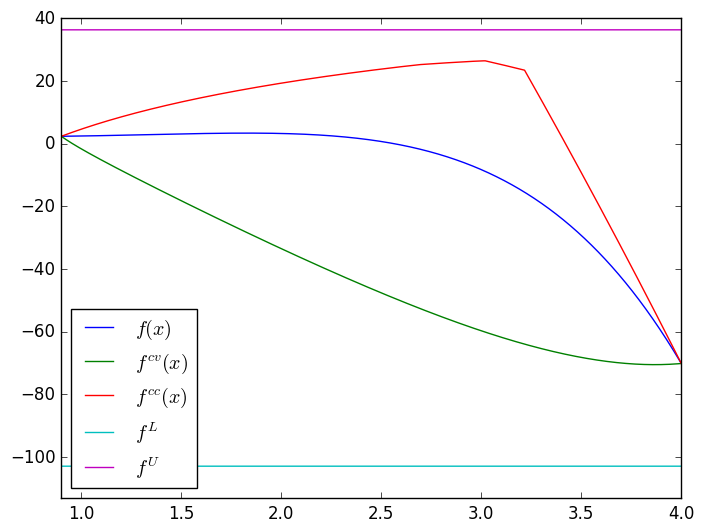

In [12]:
f(x) = (x+4.0)/exp(x)+x^2.5-sqrt(x)+log(2*x)-0.1*x^5;
I = (0.9..4.0);
mcPlot(f,I);

Note that the McCormick relaxations bound the function much more closely than the interval technique. However, the concave overestimator is not differentiable everywhere. 

Note that if we change the box on which the intervals are constructed, they rapidly converge to the true range of the function:

Interact.Slider{Int64}(Signal{Int64}(5, nactions=0),"endpoint",5,1:10,true)

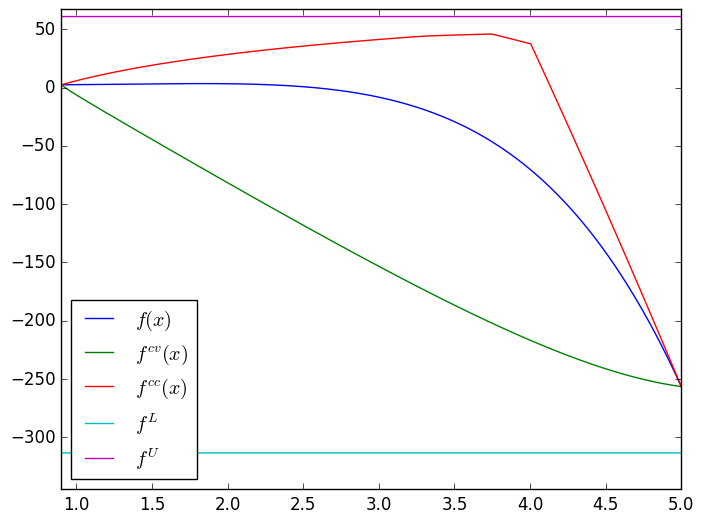

In [13]:
fig=figure()
@manipulate for endpoint=1:10
    I = (0.9..endpoint)
    withfig(fig) do
        mcPlot(f,I)
    end
end

### Global optimization example, revisited

Now we resolve the previous problem using McCormick's technique to construct the relaxations. For the lower-bounding problem, the following convex program is constructed and solved at each node visited: 

  \begin{align}
    \min_{\mathbf{x}\in X} \; & f^{cv}(\mathbf{x}) \\
    \text{s.t.} \quad & g^{cv}(\mathbf{x})\leq\mathbf{0}, \\
    & h^{cv}(\mathbf{x})\leq \mathbf{0}\leq h^{cc}(\mathbf{x}).\\
  \end{align}
  

First we write new the lower-bounding problem and some wrappers for our objective function (and constraints if we have any) so that NLopt can solve for the lower bound.

In [14]:
## McCormick version of lower-bounding problem
function LB_problem2(probSize::Vector{Int64}, obj::Function, conIneq::Function, conEq::Function, box::Vector{Interval{Float64}})
    
    nx = probSize[1];
    nIneq = probSize[2];
    nEq = probSize[3];
    
    opt = Opt(:LD_MMA, nx)
    
    lb = Vector{Float64}(nx);
    ub = Vector{Float64}(nx);
    x0 = Vector{Float64}(nx);

    for i=1:nx
        lb[i] = box[i].lo;
        ub[i] = box[i].hi;
        x0[i] = (lb[i] + ub[i])/2.0;
    end
    
    lower_bounds!(opt,lb);
    upper_bounds!(opt, ub);  
    
    xtol_rel!(opt,1e-4);
    
    min_objective!(opt,(x,g)->objWrapperLB(x,g,lb,ub,obj));
    
    if nIneq > 0
        tol1 = 1.0e-6*ones(nIneq);
        inequality_constraint!(opt, (f,x,g)->conIneqWrapperLB(f,x,g,lb,ub,conIneq),tol1);
    end
    if nEq > 0
        tol2 = 1.0e-6*ones(2*nEq);
        equality_constraint!(opt, (f,x,g)->conEqWrapperLB(f,x,g,lb,ub,conEq),tol2);
    end
    
    (solutionValue,solution,ret) = optimize!(opt, x0);
    
    status = (ret==:XTOL_REACHED ? true : false);

    return solution, solutionValue, status;
end

## Wrappers for providing objective and constraint info to NLopt
function objWrapperLB(x::Vector, grad::Vector, lb::Vector, ub::Vector, obj::Function)
    nx = length(x);
    xmc = Vector{mc}(nx);
    for i=1:nx
        xmc[i] = mc((lb[i]..ub[i]),x[i],nx);
    end
    for i=1:nx
        xmc[i].cvsub[i]=1.0;
        xmc[i].ccsub[i]=1.0;
    end
    
    mcFun = obj(xmc);
    if length(grad) > 0
        for i=1:nx
            grad[i] = mcFun.cvsub[i];
        end
    end
    return mcFun.cv;    
end

function conIneqWrapperLB(result::Vector, x::Vector, grad::Matrix, lb::Vector, ub::Vector, conIneq::Function)
    nx = length(x);
    xmc = Vector{mc}(nx);
    for i=1:nx
        xmc[i] = mc((lb[i]..ub[i]),x[i],nx);
    end
    for i=1:nx
        xmc[i].cvsub[i]=1.0;
        xmc[i].ccsub[i]=1.0;
    end
    
    mcCon = conIneq(xmc);
    for i = 1:length(mcCon)
        result[i] = mcCon[i].cv;
    end
    if length(grad) > 0
        for i=1:length(mcCon)
            for j=1:nx
                grad[j,i] = mcCon[i].cvsub[j];
            end
        end
    end 
end

function conEqWrapperLB(result::Vector, x::Vector, grad::Matrix, lb::Vector, ub::Vector, conEq::Function)
    nx = length(x);
    xmc = Vector{mc}(nx);
    for i=1:nx
        xmc[i] = mc((lb[i]..ub[i]),x[i],nx);
    end
    for i=1:nx
        xmc[i].cvsub[i]=1.0;
        xmc[i].ccsub[i]=1.0;
    end
    
    mcCon = conEq(xmc);
    for i = 1:length(mcCon)
        result[i] = mcCon[i].cv;
    end
    for i = 1:length(mcCon)
        result[length(mcCon)+i] = -mcCon[i].cc;
    end
    
    if length(grad) > 0
        for i=1:length(mcCon)
            for j=1:nx
                grad[j,i] = mcCon[i].cvsub[j];
            end
        end
        for i=1:length(mcCon)
            for j=1:nx
                grad[j,length(mcCon)+i] = -mcCon[i].ccsub[j];
            end
        end
    end 
end

  likely near C:\Users\Harry\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Harry\.julia\v0.5\IJulia\src\kernel.jl:31


conEqWrapperLB (generic function with 1 method)

Now, we're ready to optimize using the convex relaxations.

In [30]:
box = [(-3.0..3.0), (-3.0..3.0)];
opt = options("McCormick",1e-3,1e-8,10^5,10^5,0,0);
@time bab(sixHump, noConstraint, noConstraint, box, opt)


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.0,0.0] with value = 0.0
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.

Iteration: 84
Nodes in memory: 65
Current solution found at: [-0.126036,0.463529] with value = -0.6701878740052957
Best possible solution value (lower bound): -6.215940192812888
The bounds are 0.0% converged.

Iteration: 88
Nodes in memory: 57
Current solution found at: [0.0,-0.874995] with value = -0.7177936208022256
Best possible solution value (lower bound): -5.586407306267247
The bounds are 0.0% converged.

Iteration: 91
Nodes in memory: 53
Current solution found at: [0.0,0.874995] with value = -0.7177936208028307
Best possible solution value (lower bound): -5.586407306267247
The bounds are 0.0% converged.

Iteration: 145
Nodes in memory: 69
Current solution found at: [-0.101247,0.578018] with value = -0.9076549049782224
Best possible solution value (lower bound): -1.4203092643192115
The bounds are 48.734564065901

Due to the quadratic convergence rate of the relaxations, we can also tighten the termination tolerance dramatically and still solve the problem in a very similar amount of time (the cluster effect disappears).

In [16]:
opt = options("McCormick",1e-6,1e-8,10^5,10^5,0,0);
@time bab(sixHump, noConstraint, noConstraint, box, opt)


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.0,0.0] with value = 0.0
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.

Iteration: 84
Nodes in memory: 65
Current solution found at: [-0.126036,0.463529] with value = -0.6701878740052957
Best possible solution value (lower bound): -6.215940192812888
The bounds are 0.0% converged.

Iteration: 88
Nodes in memory: 57
Current solution found at: [0.0,-0.874995] with value = -0.7177936208022256
Best possible solution value (lower bound): -5.586407306267247
The bounds are 0.0% converged.

Iteration: 91
Nodes in memory: 53
Current solution found at: [0.0,0.874995] with value = -0.7177936208028307
Best possible solution value (lower bound): -5.586407306267247
The bounds are 0.0% converged.

Iteration: 145
Nodes in memory: 69
Current solution found at: [-0.101247,0.578018] with value = -0.9076549049782224
Best possible solution value (lower bound): -1.4203092643192115
The bounds are 48.734564065901

## Adding Constraints

Let's try adding the inequality constraint:
\begin{equation}
x_2-x_1\leq 0
\end{equation}
to the previous optimization. This should give us the global minima with the same value as the one we've found so far but with positive $x_1$ and negative $x_2$.

Note that the local solver doesn't seem to like constrained problems very much and failed for a lot of the other tests I tried. I think I need to look at more options or potentially switch to using something more robust like IPOPT.

In [35]:
function x2leqx1(x::Vector);
    return [x[2]-x[1]];
end

box = [(-3.0..3.0), (-3.0..3.0)]
opt = options("McCormick",1e-6,1e-8,10^5,10^5,1,0);
@time bab(sixHump, x2leqx1, noConstraint, box, opt)


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.0,0.0] with value = 0.0
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.



Iteration: 54
Nodes in memory: 42
Current solution found at: [0.235576,-0.985571] with value = -0.12791756764802617
Best possible solution value (lower bound): -6.215940192812888
The bounds are 0.0% converged.

Iteration: 55
Nodes in memory: 34
Current solution found at: [0.126036,-0.463529] with value = -0.6701878740052957
Best possible solution value (lower bound): -6.215940192812888
The bounds are 0.0% converged.

Iteration: 56
Nodes in memory: 30
Current solution found at: [0.0,-0.874995] with value = -0.7177936208022256
Best possible solution value (lower bound): -5.586407306267247
The bounds are 0.0% converged.

Iteration: 88
Nodes in memory: 39
Current solution found at: [0.101247,-0.578018] with value = -0.9076549049782224
Best possible solution value (lower bound): -1.4203092643192115
The bounds are 48.7345640659011% converged.

Iteration: 94
Nodes in memory: 29
Current solution found at: [0.0942407,-0.578148] with value = -0.909240397545308
Best possible solution value (lowe

In principle, we could also add equality constraints (and the code is written to accept them -- however, the solver in NLopt that works well with the nondifferentiable relaxations doesn't support them, and the other solvers do not seem very reliable. 

## Other test problems:
### Goldstein-Price function

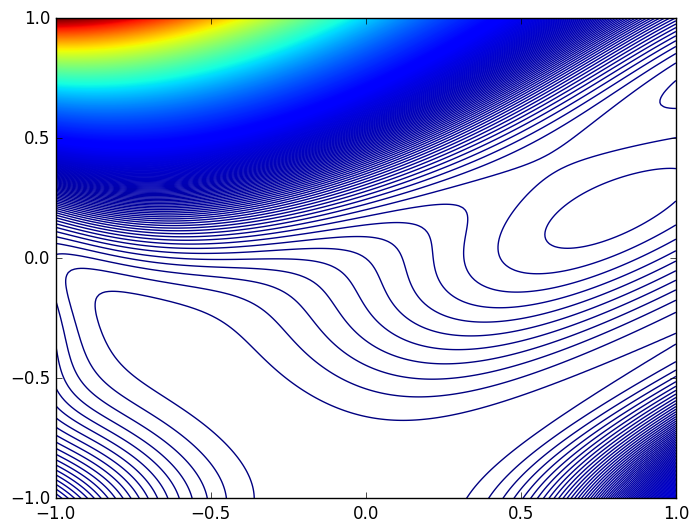

PyObject <matplotlib.contour.QuadContourSet object at 0x000000002FB82128>

In [19]:
function goldPrice(x::Vector)
    return (1+(x[1]+x[2]+1)^2*(19-14*x[1]+3*x[1]^2-14*x[2]+6*x[1]*x[2]+3*x[2]^2))*
 (30+(2*x[1]-3*x[2])^2*(18-32*x[1]+12*x[1]^2+48*x[2]-36*x[1]*x[2]+27*x[2]^2));
end

box3 = [(-2.0..2.0), (-2.0..2.0)]
opt = options("McCormick",1e-6,1e-8,10^5,10^5,0,0);

## Plot the contours
xx = collect(-1.0:0.01:1.0);
zz = Matrix(length(xx),length(xx))
for i=1:length(xx)
    for j=1:length(xx)
        zz[i,j] = goldPrice([xx[i],xx[j]])
    end
end
contour(xx,xx,zz',1000)

In [20]:
@time bab(goldPrice, noConstraint, noConstraint, box3, opt)


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.0,0.0] with value = 600.0
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.

Iteration: 2
Nodes in memory: 3
Current solution found at: [-1.0,0.0] with value = 278.0
Best possible solution value (lower bound): -8.788132e7
The bounds are 0.0% converged.

Iteration: 41
Nodes in memory: 41
Current solution found at: [0.547312,-0.451858] with value = 240.79879901458438
Best possible solution value (lower bound): -1.4809097474601008e6
The bounds are 0.0% converged.

Iteration: 84
Nodes in memory: 80
Current solution found at: [1.75,0.25] with value = 138.578125
Best possible solution value (lower bound): -571826.0
The bounds are 0.0% converged.

Iteration: 139
Nodes in memory: 125
Current solution found at: [1.875,0.25] with value = 84.939697265625
Best possible solution value (lower bound): -175259.375
The bounds are 0.0% converged.

Iteration: 157
Nodes in memory: 134
Current solution found at:

### Rosenbrock's Valley


In [21]:
function valley(x::Vector)
    return sum((x[i+1]-x[i]^2)^2+(1.0-x[i])^2 for i=1:length(x)-1);
end

n = 3; # works for n <= 3, solver seems to fail for higher n
box2 = Vector{Interval{Float64}}(n)
for i=1:n
    box2[i] = (-2.048..2.048);
end
opt = options("McCormick",1e-3,1e-8,10^5,10^5,0,0);

In [22]:
@time bab(valley, noConstraint, noConstraint, box2, opt)


Iteration: 1
Nodes in memory: 2
Current solution found at: [0.999996,1.00001,1.00169] with value = 2.7693739849400755e-6
Best possible solution value (lower bound): -1.0e50
The bounds are 0.0% converged.

Iteration: 3
Nodes in memory: 3
Current solution found at: [0.999966,0.99993,0.999829] with value = 7.04771009270293e-9
Best possible solution value (lower bound): 2.121513024383827e-10
The bounds are 99.99999931644412% converged.

Best solution found at: [0.999966,0.99993,0.999829] with value = 7.04771009270293e-9
Best possible solution value (lower bound): 2.121513024383827e-10
The bounds are 99.99999931644412% converged.
Statistics: 3 iterations
  0.289317 seconds (450.64 k allocations: 18.054 MB)
